<a href="https://colab.research.google.com/github/julicq/terminators/blob/main/Terminators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install fastbook
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 1.6 MB 3.1 MB/s 
     |████████████████████████████████| 394 kB 41.6 MB/s 
     |████████████████████████████████| 112 kB 49.4 MB/s 
     |████████████████████████████████| 556 kB 39.7 MB/s 
     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 428 kB 47.1 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '98548fb8bfee4ea1afb40b247e3f3a15')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
results = search_images_bing(key, 'terminator')
ims = results.attrgot('contentUrl')
len(ims)

150

In [7]:
ims[0]

'http://allhdwallpapers.com/wp-content/uploads/2015/04/the-terminator-5.jpg'

In [8]:
ims = ['http://allhdwallpapers.com/wp-content/uploads/2015/04/the-terminator-5.jpg']

In [9]:
dest = 'images/terminator.jpg'
download_url(ims[0], dest)

Path('images/terminator.jpg')

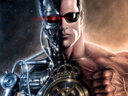

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

In [11]:
terminators = 'T-800','T-1000'
path = Path('terminators')

In [12]:
if not path.exists():
    path.mkdir()
    for o in terminators:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} terminator')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [13]:
fns = get_image_files(path)
fns

(#291) [Path('terminators/T-800/00000105.jpg'),Path('terminators/T-800/00000044.jpg'),Path('terminators/T-800/00000126.jpg'),Path('terminators/T-800/00000103.jpg'),Path('terminators/T-800/00000071.jpg'),Path('terminators/T-800/00000101.jpg'),Path('terminators/T-800/00000121.jpg'),Path('terminators/T-800/00000104.jpg'),Path('terminators/T-800/00000078.jpg'),Path('terminators/T-800/00000129.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#1) [Path('terminators/T-1000/00000007.jpg')]

In [15]:
failed.map(Path.unlink);

In [16]:
terminators = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
dls = terminators.dataloaders(path)

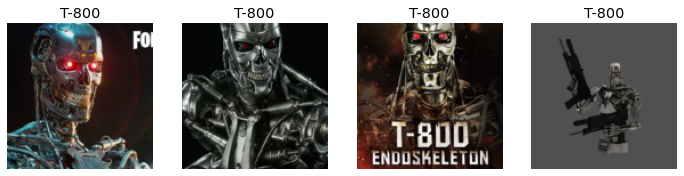

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

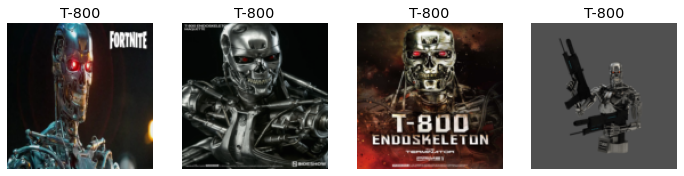

In [19]:
terminators = terminators.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = terminators.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

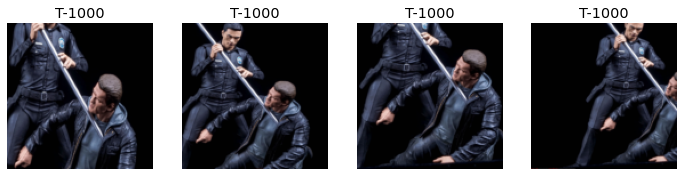

In [20]:
terminators = terminators.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = terminators.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


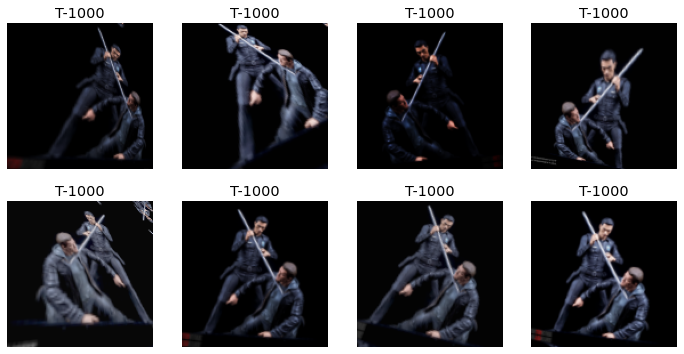

In [21]:
terminators = terminators.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = terminators.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
terminators = terminators.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = terminators.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

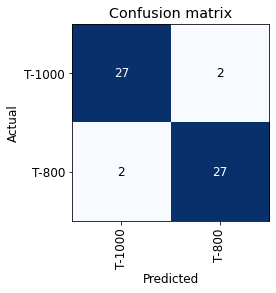

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

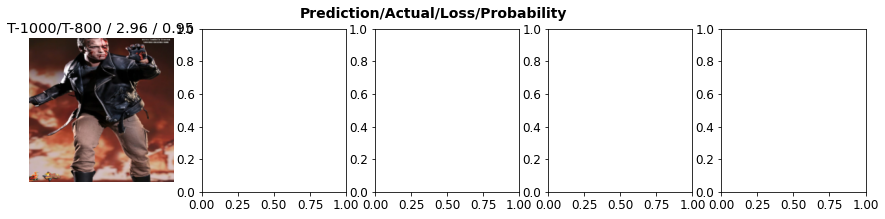

In [26]:
interp.plot_top_losses(5, nrows=1)

In [27]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [29]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [32]:
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.predict('images/terminator.jpg')

('T-800', TensorBase(1), TensorBase([0.0027, 0.9973]))

In [34]:
learn_inf.dls.vocab

['T-1000', 'T-800']

In [35]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
btn_upload = SimpleNamespace(data = ['images/terminator.jpg'])

In [37]:
img = PILImage.create(btn_upload.data[-1])

In [38]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [39]:
pred,pred_idx,probs = learn_inf.predict(img)

In [40]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: T-800; Probability: 0.9973')

In [41]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [42]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [43]:
btn_upload = widgets.FileUpload()

In [44]:
VBox([widgets.Label('Select your terminator!'), 
      btn_upload, btn_run, out_pl, lbl_pred])